<a href="https://colab.research.google.com/github/johnvalen1/Balanced-Plus-ML-Club/blob/main/Generative_Adversarial_Network_for_Handwritten_Digit_Generation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [22]:
import torch
from torch import nn

import math
import matplotlib.pyplot as plt
import torchvision
import torchvision.transforms as transforms


In [23]:
torch.manual_seed(111)


In [24]:
device = ""
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")


In [25]:
transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))]
)
train_set = torchvision.datasets.MNIST(
    root=".", train=True, download=True, transform=transform
)


In [26]:
batch_size = 32
train_loader = torch.utils.data.DataLoader(
    train_set, batch_size=batch_size, shuffle=True
)


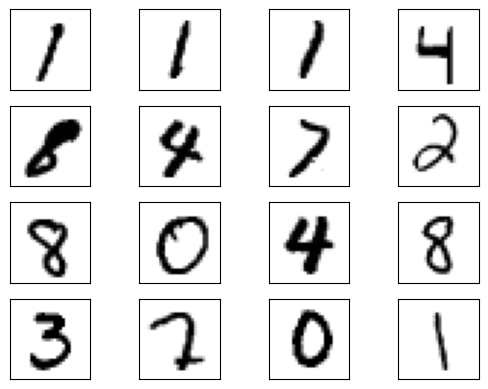

In [27]:
real_samples, mnist_labels = next(iter(train_loader))
for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(real_samples[i].reshape(28, 28), cmap="gray_r")
    plt.xticks([])
    plt.yticks([])


In [28]:
class Discriminator(nn.Module):

    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(784, 1024),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        x = x.view(x.size(0), 784)
        output = self.model(x)
        return output

In [34]:
discriminator = Discriminator().to(device=device)


In [35]:
class Generator(nn.Module):

    def __init__(self):
        super().__init__()

        self.model = nn.Sequential(
            nn.Linear(100, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 1024),
            nn.ReLU(),
            nn.Linear(1024, 784),
            nn.Tanh(),

        )

    def forward(self, x):
        output = self.model(x)
        output = output.view(x.size(0), 1, 28, 28)
        return output

generator = Generator().to(device=device)

In [31]:
lr = 0.001
num_epochs = 300
loss_function = nn.BCELoss()

optimizer_discriminator = torch.optim.Adam(discriminator.parameters(), lr=lr)
optimizer_generator = torch.optim.Adam(generator.parameters(), lr=lr)


In [33]:
for epoch in range(num_epochs):

    for n, (real_samples, mnist_labels) in enumerate(train_loader):
        # Data for training the discriminator
        real_samples = real_samples.to(device=device)
        real_samples_labels = torch.ones((batch_size, 1)).to(
            device=device

        )

        latent_space_samples = torch.randn((batch_size, 100)).to(
            device=device

        )

        generated_samples = generator(latent_space_samples)
        generated_samples_labels = torch.zeros((batch_size, 1)).to(
            device=device

        )

        all_samples = torch.cat((real_samples, generated_samples))
        all_samples_labels = torch.cat(
            (real_samples_labels, generated_samples_labels)

        )


        # Training the discriminator
        discriminator.zero_grad()
        output_discriminator = discriminator(all_samples)
        loss_discriminator = loss_function(
            output_discriminator, all_samples_labels

        )
        loss_discriminator.backward()
        optimizer_discriminator.step()


        # Data for training the generator

        latent_space_samples = torch.randn((batch_size, 100)).to(
            device=device

        )


        # Training the generator
        generator.zero_grad()
        generated_samples = generator(latent_space_samples)
        output_discriminator_generated = discriminator(generated_samples)
        loss_generator = loss_function(
            output_discriminator_generated, real_samples_labels

        )

        loss_generator.backward()
        optimizer_generator.step()


        # Show loss
        if n == batch_size - 1:
            print(f"Epoch: {epoch} Loss Discriminator.: {loss_discriminator}")
            print(f"Epoch: {epoch} Loss Generator.: {loss_generator}")

Epoch: 0 Loss Discriminator.: 0.22239172458648682
Epoch: 0 Loss Generator.: 2.9490671157836914
Epoch: 1 Loss Discriminator.: 0.6460404992103577
Epoch: 1 Loss Generator.: 2.199553966522217
Epoch: 2 Loss Discriminator.: 0.5386562347412109
Epoch: 2 Loss Generator.: 0.699371874332428
Epoch: 3 Loss Discriminator.: 0.01723233424127102
Epoch: 3 Loss Generator.: 31.913867950439453
Epoch: 4 Loss Discriminator.: 0.0013268660986796021
Epoch: 4 Loss Generator.: 46.62338638305664


In [36]:
latent_space_samples = torch.randn(batch_size, 100).to(device=device)
generated_samples = generator(latent_space_samples)


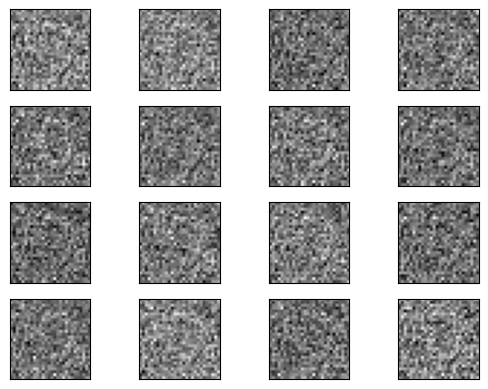

In [37]:
generated_samples = generated_samples.cpu().detach()
for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(generated_samples[i].reshape(28, 28), cmap="gray_r")
    plt.xticks([])
    plt.yticks([])
